In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from scipy.stats import linregress

In [2]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

### re-run 10 weeks after set up with the short-term rider and driver's elasticity

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01

In [4]:
demand_columns = ["request_timestamp", "x_start", "y_start", "x_end", "y_end"
                    , "rider_idx", "trip_start_subblock_id", "trip_end_subblock_id"]
supply_columns = ["idle_start_timestamp", "idle_duration", "idle_x_start", "idle_y_start"
                   , "driver_idx", "idle_start_subblock_id"]

In [5]:
total_weeks = 100
a_r = 1.5
b_r = -0.4

stdout_logger = utils.create_logger_custom("weekly_daily_main_function")

for w in tqdm(range(total_weeks)):
    simulation_this_week = WeeklySimulation(w, lr, T0_pricing_params)
    simulation_this_week.b_r = b_r
    simulation_this_week.a_r = a_r
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()
        

        lst1 = []
        for row in simulation_this_week.D_Requests:
            row_dict = {demand_columns[i]: row[i].item() for i in range(row.size(0))}
            lst1.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.4/demand_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst1, json_file, indent=4)

        lst2 = []
        for row in simulation_this_week.S_Drivers:
            row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
            lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.4/supply_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst2, json_file, indent=4)

        simulation_this_week.request_driver_matching(verbose=1)
        simulation_this_week.update_gamma_distns()
        std_out_entry = {
            "week": w,
            "day": d,
            "drivers_size": list(drivers_this_week_today.size()),
            "requests_size": list(requests_this_week_today.size())
        }
        stdout_logger.debug(json.dumps(std_out_entry))

  0%|          | 1/1000 [00:00<11:52,  1.40it/s]

100%|██████████| 1000/1000 [15:48<00:00,  1.05it/s]


In [6]:
weekly_sim_log_df = pd.read_json("../data/100_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_0_.log", lines=True)

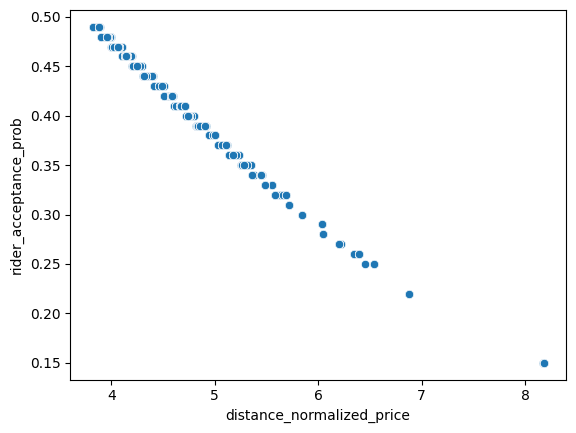

In [7]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [8]:
weekly_sim_log_df.shape

(1247, 12)

In [9]:
weekly_sim_log_df.columns

Index(['current_day', 'square_index', 'rider_id', 'driver_idx',
       'trip_start_timestamp', 'trip_duration', 'ride_miles',
       'trip_end_timestamp', 'price_of_ride', 'distance_normalized_price',
       'rider_acceptance_prob', 'driver_acceptance_prob'],
      dtype='object')

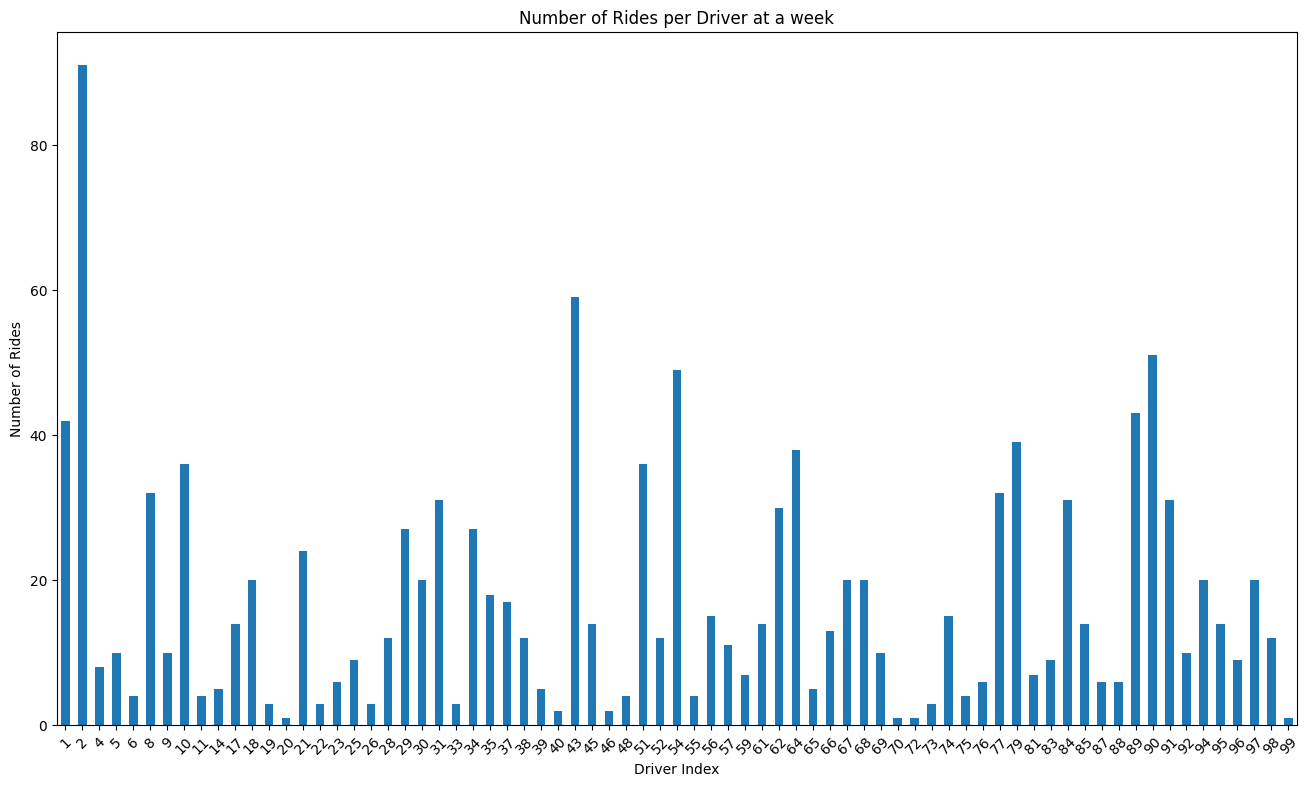

In [10]:
weekly_riders_per_driver = weekly_sim_log_df.groupby('driver_idx')['rider_id'].count()
weekly_riders_per_driver.plot(kind='bar', figsize=(16, 9))
plt.xlabel('Driver Index')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Driver at a week')
plt.xticks(rotation=45)
plt.show()

### as shown below, on avg. a driver did 24.2 riders per week

In [11]:
weekly_sim_log_df.groupby('driver_idx')['rider_id'].count().mean()

17.08219178082192

In [12]:
weekly_sim_log_df['distance_normalized_price'].mean(), weekly_sim_log_df['rider_acceptance_prob'].mean()

(4.516527666399358, 0.4258620689655173)

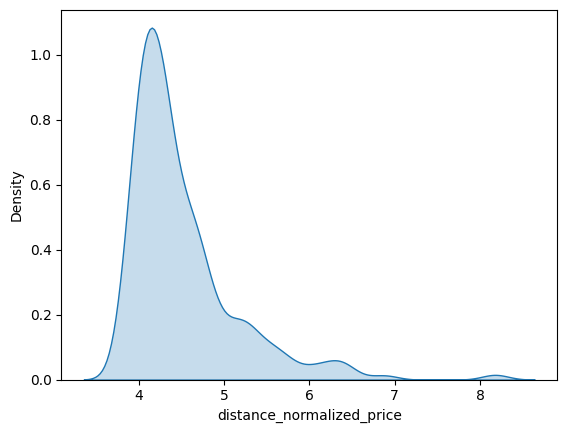

In [13]:
sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
plt.show()

### multi-normal distribution on 8am(480) and 6pm(1080)

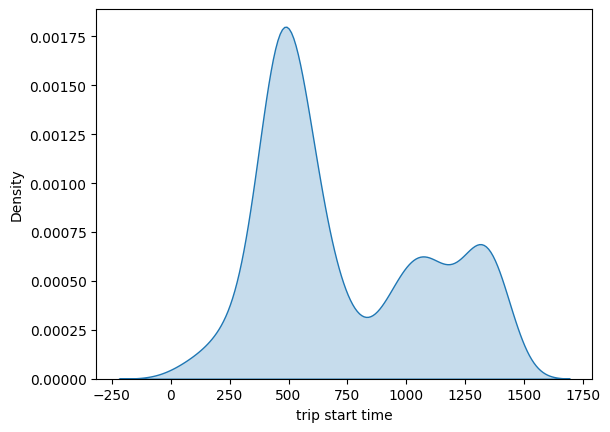

In [14]:
sns.kdeplot(data=weekly_sim_log_df['trip_start_timestamp'], fill=True)
plt.xlabel('trip start time')
plt.show()

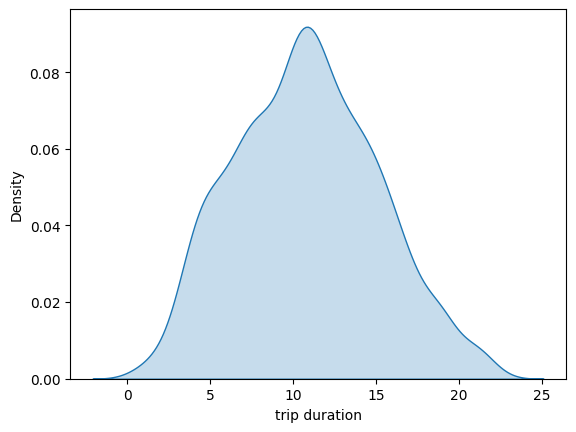

In [15]:
sns.kdeplot(data=weekly_sim_log_df['trip_duration'], fill=True)
plt.xlabel('trip duration')
plt.show()

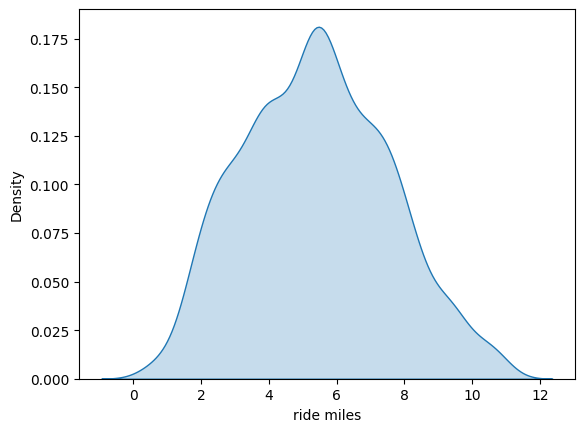

In [16]:
sns.kdeplot(data=weekly_sim_log_df['ride_miles'], fill=True)
plt.xlabel('ride miles')
plt.show()

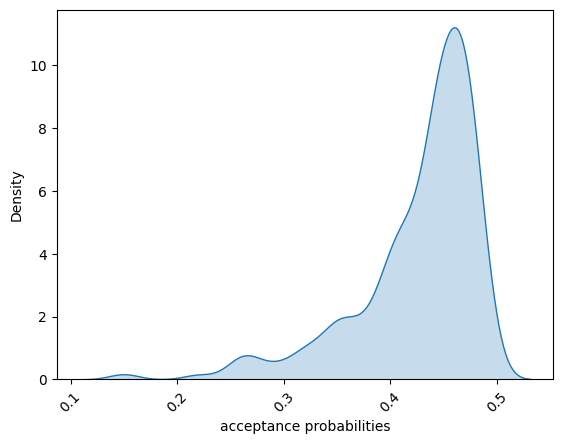

In [17]:
sns.kdeplot(data=weekly_sim_log_df['rider_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

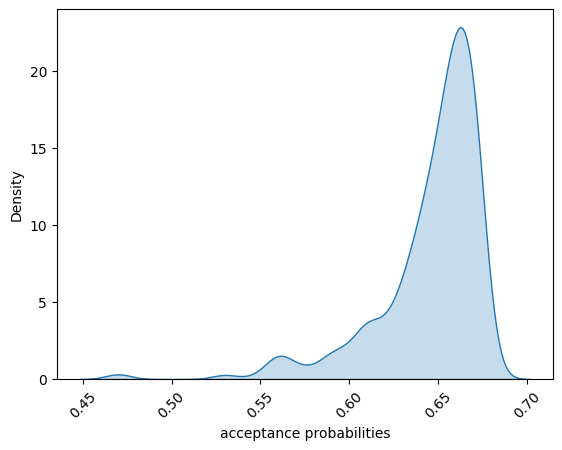

In [18]:
sns.kdeplot(data=weekly_sim_log_df['driver_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

In [19]:
daily_avg_price_lst, daily_total_requests = [], []
for i in range(1000):
    trips_df = pd.read_json('../data/100_weeks_a_r1.5_b_r-0.4/logfile_matched_trips_week_'+str(i)+'_.log', lines=True)
    requests_df = pd.read_json('../data/100_weeks_a_r1.5_b_r-0.4/demand_week_'+str(i)+'.json')
    daily_avg_price_lst.append(trips_df.price_of_ride.mean()) 
    daily_total_requests.append(len(requests_df))

In [20]:
daily_avg_price_lst, daily_total_requests

([23.24990376904571,
  24.496394716394718,
  24.645146147032776,
  23.670499168053244,
  24.065713004484305,
  24.37249581239531,
  25.466755555555554,
  24.425752153744202,
  24.594692502106152,
  24.52596638655462,
  23.968233510235027,
  23.907412116679133,
  24.65155821917808,
  24.560000000000002,
  24.418024596464257,
  24.432053506869124,
  24.672686440677964,
  24.915526315789474,
  24.7457034795764,
  24.560188405797106,
  23.934363827549948,
  24.467288135593222,
  23.77513855898654,
  23.66985237483954,
  24.12396085740913,
  24.51542258788332,
  24.151173469387754,
  25.06928476821192,
  25.04543613707165,
  24.498434559452527,
  23.197100591715976,
  24.878334866605336,
  24.135303159692572,
  24.295471698113207,
  24.533055773762765,
  24.175880913539967,
  24.43859510655091,
  23.7559898904802,
  24.304237573715245,
  23.545816409423235,
  24.49790425531915,
  24.96413983440662,
  24.563241224794623,
  24.594647266313935,
  23.70057917888563,
  24.241822863027803,
  23.9

In [21]:
long_term_rider_elasticity_df = pd.DataFrame({'daily_avg_price': daily_avg_price_lst, 'daily_total_requests': daily_total_requests})

In [22]:
long_term_rider_elasticity_df['daily_avg_price_change'] = long_term_rider_elasticity_df['daily_avg_price'].pct_change()

In [23]:
long_term_rider_elasticity_df['daily_total_requests_change'] = long_term_rider_elasticity_df['daily_total_requests'].pct_change()

In [24]:
long_term_rider_elasticity_df.daily_avg_price.mean(), long_term_rider_elasticity_df.daily_total_requests.mean()

(24.305741144800436, 997.081)

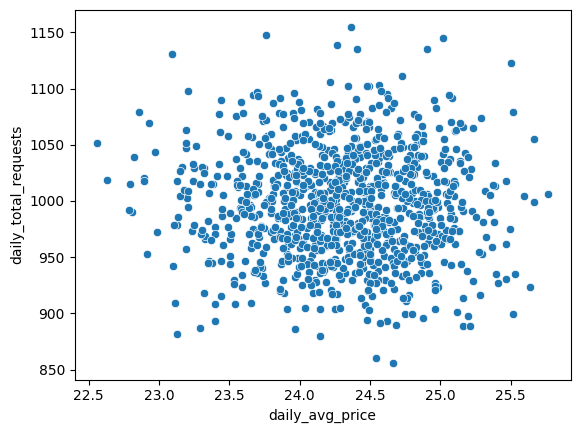

In [25]:
sns.scatterplot(data=long_term_rider_elasticity_df, x='daily_avg_price', y='daily_total_requests')
plt.show()

In [26]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-3.4492730155956206,
 1080.9181370548124,
 -0.03943327268493216,
 0.21279577038989322,
 2.7666967196883854)

### roughly 4.3%(i.e. 1 / 23) increase of ride price will cause a drop of 4.5%(i.e. 46/1022) for the next day's requests

In [27]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-3.4492730155956206,
 1080.9181370548124,
 -0.03943327268493216,
 0.21279577038989322,
 2.7666967196883854)

### as below, the ride share company makes $7.1 per ride

In [28]:
round(weekly_sim_log_df['price_of_ride'].mean(), 2), weekly_sim_log_df['price_of_ride'].sum()

(23.25, 28992.629999999997)

In [29]:
round(weekly_sim_log_df['price_of_ride'].mean()*0.3, 2)

6.97